In [1]:
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.stats import randint
import numpy as np

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
rng = np.random.RandomState(0)

X, y = datasets.make_classification(n_samples=400, n_features=12, random_state=rng)

clf = RandomForestClassifier(n_estimators=20, random_state=rng)

param_dist = {
    "max_depth": [3, None],
    "max_features": randint(1, 6),
    "min_samples_split": randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_dist, factor=2, random_state=rng
)
rsh.fit(X, y)


HalvingRandomSearchCV(estimator=RandomForestClassifier(n_estimators=20,
                                                       random_state=RandomState(MT19937) at 0x7FCD1D2AADB0),
                      factor=2,
                      param_distributions={'bootstrap': [True, False],
                                           'criterion': ['gini', 'entropy'],
                                           'max_depth': [3, None],
                                           'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcdd3b55278>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcd1af44ac8>},
                      random_state=RandomState(MT19937) at 0x7FCD1D2AADB0,
                      refit=<function _refit_callable at 0x7fcd1e81dbf8>)

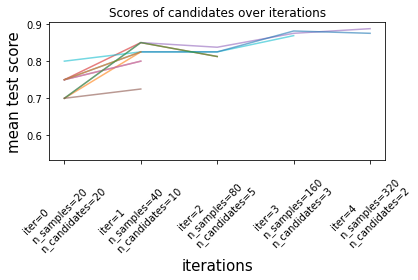

In [3]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]

ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

In [4]:
y

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,

In [5]:
# Define the headers since the data does not have any
headers = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration",
           "num_doors", "body_style", "drive_wheels", "engine_location",
           "wheel_base", "length", "width", "height", "curb_weight",
           "engine_type", "num_cylinders", "engine_size", "fuel_system",
           "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm",
           "city_mpg", "highway_mpg", "price"]

# Read in the CSV file and convert "?" to NaN
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
                  header=None, names=headers, na_values="?" )
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [6]:
from scipy.io import arff

In [7]:
churn_data = arff.loadarff("../data/chrun.arff")

In [8]:
churn_df = pd.DataFrame(churn_data[0])

In [9]:
churn_df["number_customer_service_calls"] = churn_df["number_customer_service_calls"].astype(int)

In [10]:
churn_df

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
0,16.0,128.0,b'415',2845.0,b'0',b'1',25.0,265.1,110.0,45.07,...,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,b'0'
1,35.0,107.0,b'415',2301.0,b'0',b'1',26.0,161.6,123.0,27.47,...,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,b'0'
2,31.0,137.0,b'415',1616.0,b'0',b'0',0.0,243.4,114.0,41.38,...,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,b'0'
3,35.0,84.0,b'408',2510.0,b'1',b'0',0.0,299.4,71.0,50.90,...,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,b'0'
4,36.0,75.0,b'415',155.0,b'1',b'0',0.0,166.7,113.0,28.34,...,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,b'0'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11.0,50.0,b'408',2000.0,b'0',b'1',40.0,235.7,127.0,40.07,...,126.0,18.96,297.5,116.0,13.39,9.9,5.0,2.67,2,b'0'
4996,49.0,152.0,b'415',394.0,b'0',b'0',0.0,184.2,90.0,31.31,...,73.0,21.83,213.6,113.0,9.61,14.7,2.0,3.97,3,b'1'
4997,7.0,61.0,b'415',313.0,b'0',b'0',0.0,140.6,89.0,23.90,...,128.0,14.69,212.4,97.0,9.56,13.6,4.0,3.67,1,b'0'
4998,7.0,109.0,b'510',3471.0,b'0',b'0',0.0,188.8,67.0,32.10,...,92.0,14.59,224.4,89.0,10.10,8.5,6.0,2.30,0,b'0'


In [11]:
churn_df[churn_df.isnull().any(axis=1)]

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class


In [12]:
test_data = pd.DataFrame({"catA":["A", "B", np.NaN, "C", "D"], 
                          "catB":[np.NaN, "B", "C", "D", "R"],
                          "numA":[1, 2, 3, np.NaN, 3],
                          "numB":[np.NaN, 4, 5, 4, 5]})
test_data

,catA,catB,numA,numB
0,A,NaN,1.0,NaN
1,B,B,2.0,4.0
2,NaN,C,3.0,5.0
3,C,D,NaN,4.0
4,D,R,3.0,5.0


In [13]:
from sklearn.impute import SimpleImputer

In [14]:
cat_test = test_data.select_dtypes(include=["object"]).copy()
cat_test.fillna("missing", inplace=True)
cat_test

,catA,catB
0,A,missing
1,B,B
2,missing,C
3,C,D
4,D,R


In [15]:
num_test = test_data.select_dtypes(include=["float64"]).copy()
num_test

,numA,numB
0,1.0,NaN
1,2.0,4.0
2,3.0,5.0
3,NaN,4.0
4,3.0,5.0


In [16]:
si = SimpleImputer(missing_values=np.nan, strategy='mean')
numerical_noNA = pd.DataFrame(si.fit_transform(num_test), columns=num_test.columns)

In [17]:
test_noNA = numerical_noNA.join(cat_test)
test_noNA

,numA,numB,catA,catB
0,1.00,4.5,A,missing
1,2.00,4.0,B,B
2,3.00,5.0,missing,C
3,2.25,4.0,C,D
4,3.00,5.0,D,R


# Train test

In [18]:
from sklearn.model_selection import train_test_split
import category_encoders as ce

In [19]:
X_complete = churn_df.drop(columns="class")
y_complete = churn_df[["class"]]


X_train, X_validation, y_train, y_validation = train_test_split(X_complete, y_complete, 
                                                                test_size=0.3, stratify=y_complete)

In [20]:
dataset_dict = {"X_train": X_train,
                    "X_validation": X_validation,
                    "y_train": y_train,
                    "y_validation": y_validation}

In [21]:
X_train.shape[0] == y_train.shape[0]

True

# Preprocess

In [22]:
import itertools
from preprocessing_dictionaries import category_strategy_dict, numerical_strategy_dict

In [23]:
numerical_strategy_dict

{'SSE': StandardScaler(),
 'MMS': MinMaxScaler(clip=True),
 'LOG': FunctionTransformer(func=<ufunc 'log2'>)}

In [24]:
cat_strat = ["OHE", "BDE", "SUM"]
num_strat = ["SSE", "MMS", "LOG"]

for cat, num in itertools.product(cat_strat, num_strat):
    print(f"{cat}-{num}")

OHE-SSE
OHE-MMS
OHE-LOG
BDE-SSE
BDE-MMS
BDE-LOG
SUM-SSE
SUM-MMS
SUM-LOG


In [25]:
categoric_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
numerical_columns = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [26]:
from sklearn.compose import ColumnTransformer

In [27]:
transformed_data = {}
object_dict = {}
for cat, num in itertools.product(cat_strat, num_strat):
    ct = ColumnTransformer([(cat, category_strategy_dict[cat], categoric_columns),
                            (num, numerical_strategy_dict[num], numerical_columns)],
                            remainder='passthrough')
    
    transformed_data[f"{cat}-{num}"] = ct.fit_transform(X_train)
    object_dict[f"{cat}-{num}"] = ct
                           

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log2
  return func(X, **(kw_args if kw_args else {}))
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log2
  return func(X, **(kw_args if kw_args else {}))
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log2
  return func(X, **(kw_args if kw_args else {}))


In [28]:
object_dict["BDE-MMS"]

ColumnTransformer(remainder='passthrough',
                  transformers=[('BDE', BackwardDifferenceEncoder(),
                                 ['area_code', 'international_plan',
                                  'voice_mail_plan']),
                                ('MMS', MinMaxScaler(clip=True),
                                 ['state', 'account_length', 'phone_number',
                                  'number_vmail_messages', 'total_day_minutes',
                                  'total_day_calls', 'total_day_charge',
                                  'total_eve_minutes', 'total_eve_calls',
                                  'total_eve_charge', 'total_night_minutes',
                                  'total_night_calls', 'total_night_charge',
                                  'total_intl_minutes', 'total_intl_calls',
                                  'total_intl_charge',
                                  'number_customer_service_calls'])])

In [29]:
pd.DataFrame(transformed_data["BDE-SSE"])

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,-0.666667,-0.333333,-0.5,-0.5,-1.006951,-0.336339,-0.541190,1.486184,-0.529139,...,-0.953622,-0.158408,-0.954608,0.989361,0.445534,0.987332,-3.750722,-1.797253,-3.751753,-0.430919
1,1.0,0.333333,-0.333333,0.5,0.5,1.218345,1.522521,-1.692030,-0.575506,0.262245,...,0.987752,0.243424,0.987935,1.084290,1.441269,1.084019,0.968081,-1.392700,0.963406,-0.430919
2,1.0,0.333333,0.666667,-0.5,-0.5,-1.276684,-1.039691,1.165565,1.338920,0.469336,...,-1.702152,0.745713,-1.701015,0.289259,1.491056,0.288546,-0.312214,-0.988148,-0.310229,2.633005
3,1.0,0.333333,0.666667,-0.5,0.5,0.409146,0.115816,-0.465953,-0.575506,0.253000,...,-0.337186,1.197773,-0.337703,1.851634,-1.396575,1.853122,0.199904,0.225509,0.204645,-0.430919
4,1.0,-0.666667,-0.333333,-0.5,-0.5,0.813745,-0.989451,-1.180004,2.369765,-1.387088,...,-0.389222,-0.007721,-0.389504,-0.513683,0.744255,-0.515716,-0.019575,-0.988148,-0.025693,0.335062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,1.0,0.333333,-0.333333,-0.5,0.5,-1.276684,-0.537296,0.157535,-0.575506,-0.349783,...,-0.589364,0.544797,-0.589645,1.469940,-0.998281,1.470768,-0.970652,-0.988148,-0.974145,0.335062
3496,1.0,0.333333,0.666667,-0.5,0.5,-1.546417,2.326352,1.244982,-0.575506,0.519260,...,-0.441259,0.193195,-0.441305,-0.082546,-0.251480,-0.080623,0.785182,1.843719,0.787265,1.101043
3497,1.0,0.333333,0.666667,-0.5,0.5,-0.332619,0.291654,1.023452,-0.575506,0.099531,...,-0.173069,0.946629,-0.172881,-1.108967,-1.097854,-1.109025,-0.092735,2.652823,-0.093440,0.335062
3498,1.0,0.333333,-0.333333,-0.5,0.5,-0.467486,2.301232,-0.189389,-0.575506,-0.102014,...,0.653516,0.092737,0.653582,-1.949485,-1.595722,-1.948446,0.785182,-0.179043,0.787265,-0.430919


Testing AutoML

In [30]:
from automl import automl

In [31]:
test_y = pd.DataFrame({"response":[1, 1, 1, 0, 0]})
assert test_y.shape[0] == test_data.shape[0]

In [32]:
auto_output = automl(test_data, test_y, test_fraction=2)

['SSE', 'MMS', 'LOG']


In [38]:
pd.DataFrame(auto_output["BDE-LOG"])

,0,1,2,3,4,5,6
0,1.0,-0.666667,-0.333333,-0.666667,-0.333333,1.585011,2.321957
1,1.0,0.333333,-0.333333,0.333333,-0.333333,1.000072,2.000036
2,1.0,0.333333,0.666667,0.333333,0.666667,1.585011,2.321957
